Normal Data - Max: 5.0408563999786296, Mean: 1.1309608565033256, Std: 0.8347198511834911
Bias Data - Max: 8.606356313241445, Mean: 1.6226284310312296, Std: 1.268035076478772
Recommended Threshold: 6.823606356610037


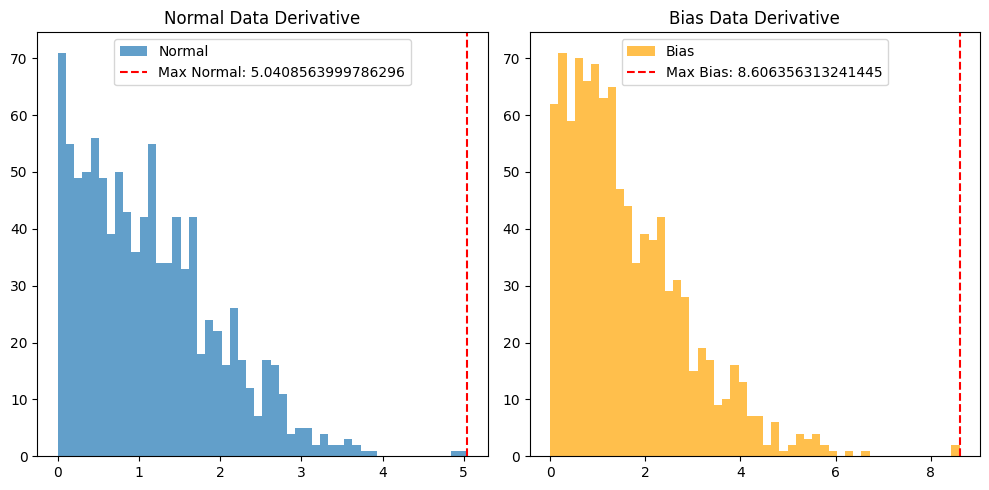

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load your data here (replace with actual data)
# Example: Assuming data is in the form of lists or arrays
normal_data = np.random.normal(0, 1, 1000)  # Replace with real normal data
bias_data = np.random.normal(0, 1.5, 1000) + 5  # Replace with real biased data

# Function to compute the numerical derivative
def compute_derivative(data):
    return np.diff(data)  # Difference between successive points

# Compute derivatives for normal and biased data
normal_derivative = compute_derivative(normal_data)
bias_derivative = compute_derivative(bias_data)

# Analyze the derivative statistics
normal_max = np.max(np.abs(normal_derivative))
normal_mean = np.mean(np.abs(normal_derivative))
normal_std = np.std(np.abs(normal_derivative))

bias_max = np.max(np.abs(bias_derivative))
bias_mean = np.mean(np.abs(bias_derivative))
bias_std = np.std(np.abs(bias_derivative))

print(f"Normal Data - Max: {normal_max}, Mean: {normal_mean}, Std: {normal_std}")
print(f"Bias Data - Max: {bias_max}, Mean: {bias_mean}, Std: {bias_std}")

# Determine a threshold - Example: Mean of max normal and max bias
threshold = (normal_max + bias_max) / 2
print(f"Recommended Threshold: {threshold}")

# Visualization for analysis
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.title("Normal Data Derivative")
plt.hist(np.abs(normal_derivative), bins=50, alpha=0.7, label='Normal')
plt.axvline(normal_max, color='r', linestyle='--', label=f"Max Normal: {normal_max}")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Bias Data Derivative")
plt.hist(np.abs(bias_derivative), bins=50, alpha=0.7, color='orange', label='Bias')
plt.axvline(bias_max, color='r', linestyle='--', label=f"Max Bias: {bias_max}")
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import numpy as np

WINDOW_SIZE = 10
GYRO_THRESHOLD = 5.0
DERIVATIVE_THRESHOLD = 0.5

def moving_average_filter(data, window_size):
    """
    Calculate the moving average of the data using a specified window size.
    """
    smoothed_data = np.convolve(data, np.ones(window_size), 'valid') / window_size
    return smoothed_data

def trend_recovery(data, window_size):
    """
    Perform trend recovery using a moving average window filter on the data.
    """
    size = len(data)
    filtered_data = moving_average_filter(data, window_size)
    original_mean = np.mean(data)  # Calculate the mean of the original data

    # Adjust the size of filtered_data to match original data size by padding the boundaries
    pad_size = (size - len(filtered_data)) // 2
    filtered_data = np.pad(filtered_data, (pad_size, size - len(filtered_data) - pad_size), 'edge')

    # Perform trend recovery by correcting the data
    recovered_data = data - filtered_data + original_mean
    return recovered_data

def check_and_recover_bias(sensor_data, metrics):
    """
    Detects bias based on accelerometer and gyroscope data, and recovers the data if bias is detected.
    
    Parameters:
    - sensor_data: A dictionary containing 'acceleration', 'gyroscope', and 'battery_voltage'.
    - metrics: A dictionary containing 'acceleration_size' and 'gyroscope_size'.
    
    Returns:
    A string indicating the result of the bias check and recovery process.
    """
    acceleration = sensor_data['acceleration']
    gyroscope = sensor_data['gyroscope']
    battery_voltage = sensor_data['battery_voltage']
    
    # Apply a moving average filter to smooth the acceleration data
    smoothed_accel = moving_average_filter(acceleration, WINDOW_SIZE)
    
    # Find the maximum numerical derivative of the smoothed data
    derivatives = np.abs(np.diff(smoothed_accel))
    max_derivative_index = np.argmax(derivatives)
    max_derivative = derivatives[max_derivative_index]

    # Check if the maximum derivative exceeds the threshold
    if max_derivative > DERIVATIVE_THRESHOLD:
        # Check battery voltage at the point of the maximum derivative
        if battery_voltage[max_derivative_index * WINDOW_SIZE] == 3.4:
            return "Bias detected due to low battery voltage.\nPlease charge the battery!"

    # Check for bias due to sudden rotation using gyroscope data
    if np.any(np.abs(gyroscope) > GYRO_THRESHOLD):
        # Bias detected due to sudden rotation, apply data recovery
        bias_index = max_derivative_index * WINDOW_SIZE

        # Split the data into two segments: before and after the bias
        before_bias = acceleration[:bias_index]
        after_bias = acceleration[bias_index:]

        # Apply trend recovery separately on both segments
        before_bias_recovered = trend_recovery(before_bias, WINDOW_SIZE)
        after_bias_recovered = trend_recovery(after_bias, WINDOW_SIZE)

        # Combine the recovered data
        recovered_data = np.concatenate((before_bias_recovered, after_bias_recovered))

        # Update the original acceleration data with the recovered data
        sensor_data['acceleration'] = recovered_data

        return "Bias detected due to sudden rotation and recovered!"
    
    return "No bias detected"

# Example usage:
sensor_data = {
    'acceleration': np.random.randn(100),  # Example random acceleration data
    'gyroscope': np.random.randn(100),     # Example random gyroscope data
    'battery_voltage': np.random.uniform(3.0, 4.0, 100)  # Example battery voltage data
}

metrics = {
    'acceleration_size': len(sensor_data['acceleration']),
    'gyroscope_size': len(sensor_data['gyroscope'])
}

result = check_and_recover_bias(sensor_data, metrics)
print(result)


No bias detected
